# Simple train

В этом ноутбуке по данным из соревнования просто построим бейзлайн модельку по типу логрега, сохраним ее в виде пикла и положим в отдельную директорию для того чтобы в дальнейшем брать эти веса в модел врпапер и использовать их

In [1]:
# base
import os

import sys, multiprocessing, psutil
import time
from typing import Union, List, Tuple, Callable, Dict

import numpy as np
import pandas as pd

import random

from collections import Counter, defaultdict

import string

import re

import joblib

# plotting
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

# ML
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import HistGradientBoostingClassifier # fast gradient boosting (as dataset is under million samples)

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.metrics import f1_score, precision_score, recall_score
from scipy.stats import kruskal

import optuna

# # DL
# import torch
# from torch import nn
# from torch.nn import functional as F

# from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

# from torch.utils.data import Dataset, DataLoader


# logging
from tqdm.auto import tqdm
tqdm.pandas()

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# versions
print('=' * 50, "VERSIONS:", '-' * 50, sep='\n')
print(f"numpy=={np.__version__}")
print(f"pandas=={pd.__version__}")
# config
def set_all_seeds(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)

    # torch.manual_seed(seed)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed(seed)
    #     if torch.cuda.device_count() > 1:
    #         torch.cuda.manual_seed_all(seed)

print('=' * 50, "CONFIG:", '-' * 50, sep='\n')
ALL_SEED = 52
set_all_seeds(ALL_SEED)
print(f"seed: {ALL_SEED}")
print(f"cores: {multiprocessing.cpu_count()}")
DEVICE = "cpu"
# if torch.cuda.is_available():
#     DEVICE = "cuda"
#     print(f"torch=={torch.__version__} (CUDA: {torch.version.cuda})")
#     if torch.cuda.device_count() >= 1:
#         print(f"GPUs: {torch.cuda.device_count()} {torch.cuda.get_device_name(0)}")
# elif torch.backends.mps.is_available():
#     print(f"torch=={torch.__version__} (MPS)")
print(f"RAM: {psutil.virtual_memory().total // (1024 ** 3)}Gb")

VERSIONS:
--------------------------------------------------
numpy==2.3.4
pandas==2.3.3
CONFIG:
--------------------------------------------------
seed: 52
cores: 14
RAM: 24Gb


## Data

Начнем с простого EDA, посмотрим на данные которые у нас есть

In [2]:
df_raw = pd.read_csv('../data/raw_data/train.csv'); df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_time  786431 non-null  object 
 1   merch             786431 non-null  object 
 2   cat_id            786431 non-null  object 
 3   amount            786431 non-null  float64
 4   name_1            786431 non-null  object 
 5   name_2            786431 non-null  object 
 6   gender            786431 non-null  object 
 7   street            786431 non-null  object 
 8   one_city          786431 non-null  object 
 9   us_state          786431 non-null  object 
 10  post_code         786431 non-null  int64  
 11  lat               786431 non-null  float64
 12  lon               786431 non-null  float64
 13  population_city   786431 non-null  int64  
 14  jobs              786431 non-null  object 
 15  merchant_lat      786431 non-null  float64
 16  merchant_lon      78

In [3]:
df_raw.target.value_counts()

target
0    781927
1      4504
Name: count, dtype: int64

In [4]:
df_raw.target = df_raw.target.astype(bool)

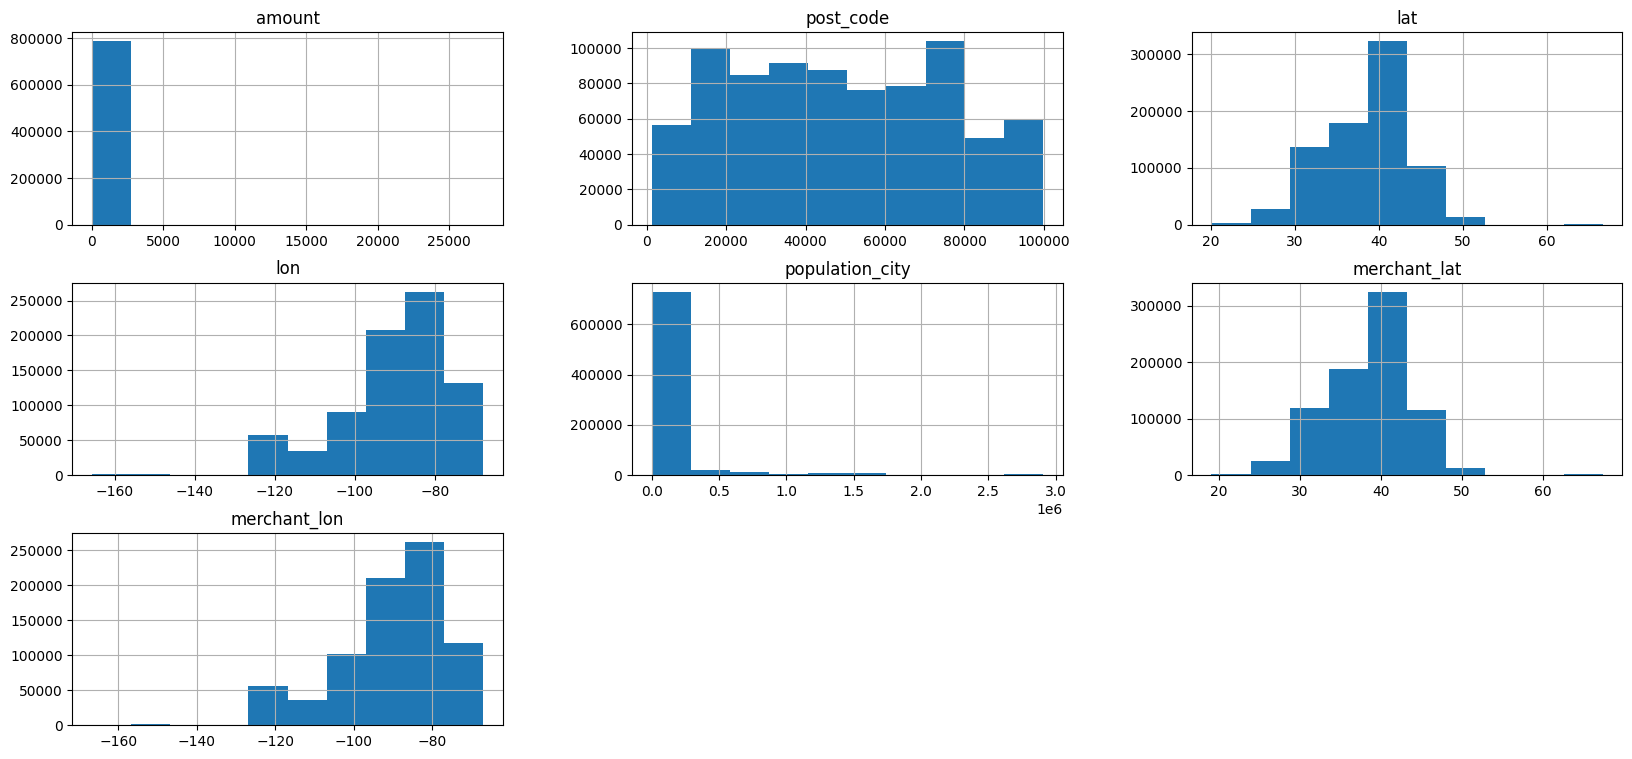

In [5]:
df_raw.select_dtypes(include=['float64', 'int64']).hist(figsize=(20,9));

In [6]:
clmns_to_remove = []
for categorical_clmn in df_raw.select_dtypes(include='object').columns:
    if len(df_raw[categorical_clmn].unique()) > 60:
        print(f"параметр - {categorical_clmn}, имеет слишком большую размерность убираем его для бейзлайна")
        clmns_to_remove.append(categorical_clmn)
    else:
        print(df_raw[categorical_clmn].value_counts())
df_raw.drop(columns=clmns_to_remove, inplace=True)

параметр - transaction_time, имеет слишком большую размерность убираем его для бейзлайна
параметр - merch, имеет слишком большую размерность убираем его для бейзлайна
cat_id
gas_transport     79995
grocery_pos       74875
home              74743
shopping_pos      70861
kids_pets         68421
shopping_net      59080
entertainment     56955
food_dining       55636
personal_care     55136
health_fitness    52025
misc_pos          48364
misc_net          38217
grocery_net       27435
travel            24688
Name: count, dtype: int64
параметр - name_1, имеет слишком большую размерность убираем его для бейзлайна
параметр - name_2, имеет слишком большую размерность убираем его для бейзлайна
gender
F    430496
M    355935
Name: count, dtype: int64
параметр - street, имеет слишком большую размерность убираем его для бейзлайна
параметр - one_city, имеет слишком большую размерность убираем его для бейзлайна
us_state
TX    57639
NY    50283
PA    48423
CA    34190
OH    28038
MI    27856
IL    26

In [7]:
df_raw.sample(10)

,cat_id,amount,gender,us_state,post_code,lat,lon,population_city,merchant_lat,merchant_lon,target
277457,personal_care,113.69,F,TX,75858,31.3833,-95.0619,43,30.576979,-94.728087,False
29461,grocery_pos,134.09,F,ME,4680,44.4971,-67.9503,1131,45.274789,-68.219073,False
436345,kids_pets,24.66,F,VA,23937,36.9688,-78.5615,1970,36.227376,-78.919854,False
704141,entertainment,93.13,F,IN,46254,39.8490,-86.2720,910148,40.326199,-86.172279,False
344801,kids_pets,89.78,M,HI,96727,20.0827,-155.4880,4878,19.409835,-155.716765,False
694418,shopping_pos,1.55,F,NY,12986,44.2320,-74.4905,6120,44.966993,-73.991568,False
250819,travel,4.40,F,OH,44233,41.2419,-81.7453,7646,40.574279,-81.780594,False
706413,shopping_pos,6.81,F,PA,15432,40.1151,-79.8627,427,39.676328,-79.986485,False
93208,travel,5.26,M,PA,15217,40.4308,-79.9205,687276,40.898027,-79.313644,False
225028,grocery_pos,79.79,F,NY,14586,43.0397,-77.6871,10256,42.265788,-77.795781,False


## Modeling

Теперь обучим базовый бустинг на гистограмах на нашем датасете, но перед этим базовые стат тесты с оставшимеся параметрами

In [8]:
X, y = df_raw.drop(columns='target'), df_raw['target']

In [9]:
numerical_features = list(df_raw.select_dtypes(include=['float64', 'int64']).columns)
categorical_features = list(df_raw.select_dtypes(include=['object']).columns)
print(f"Numerical features: {numerical_features}\nCategorical features: {categorical_features}")

Numerical features: ['amount', 'post_code', 'lat', 'lon', 'population_city', 'merchant_lat', 'merchant_lon']
Categorical features: ['cat_id', 'gender', 'us_state']


In [10]:
f_values, p_values = f_classif(pd.get_dummies(X[categorical_features], drop_first=True), y)

for i, col in enumerate(categorical_features):
    print(f"ANOVA F-test for {col}: F-value = {f_values[i]}, p-value = {p_values[i]}")
# kruskal wallis test
for col in categorical_features:
    groups = [y[X[col] == category] for category in X[col].unique()]
    H_stat, p_val = kruskal(*groups)
    print(f"Kruskal-Wallis test for {col}: H-statistic = {H_stat}, p-value = {p_val}")

ANOVA F-test for cat_id: F-value = 172.96801986520782, p-value = 1.679309657830076e-39
ANOVA F-test for gender: F-value = 16.48786577617747, p-value = 4.8967163750602915e-05
ANOVA F-test for us_state: F-value = 39.451677015792036, p-value = 3.3645358521372693e-10
Kruskal-Wallis test for cat_id: H-statistic = 3893.4841072779127, p-value = 0.0
Kruskal-Wallis test for gender: H-statistic = 38.066720306450456, p-value = 6.836632478999821e-10
Kruskal-Wallis test for us_state: H-statistic = 1285.135275106526, p-value = 3.550356536245532e-236


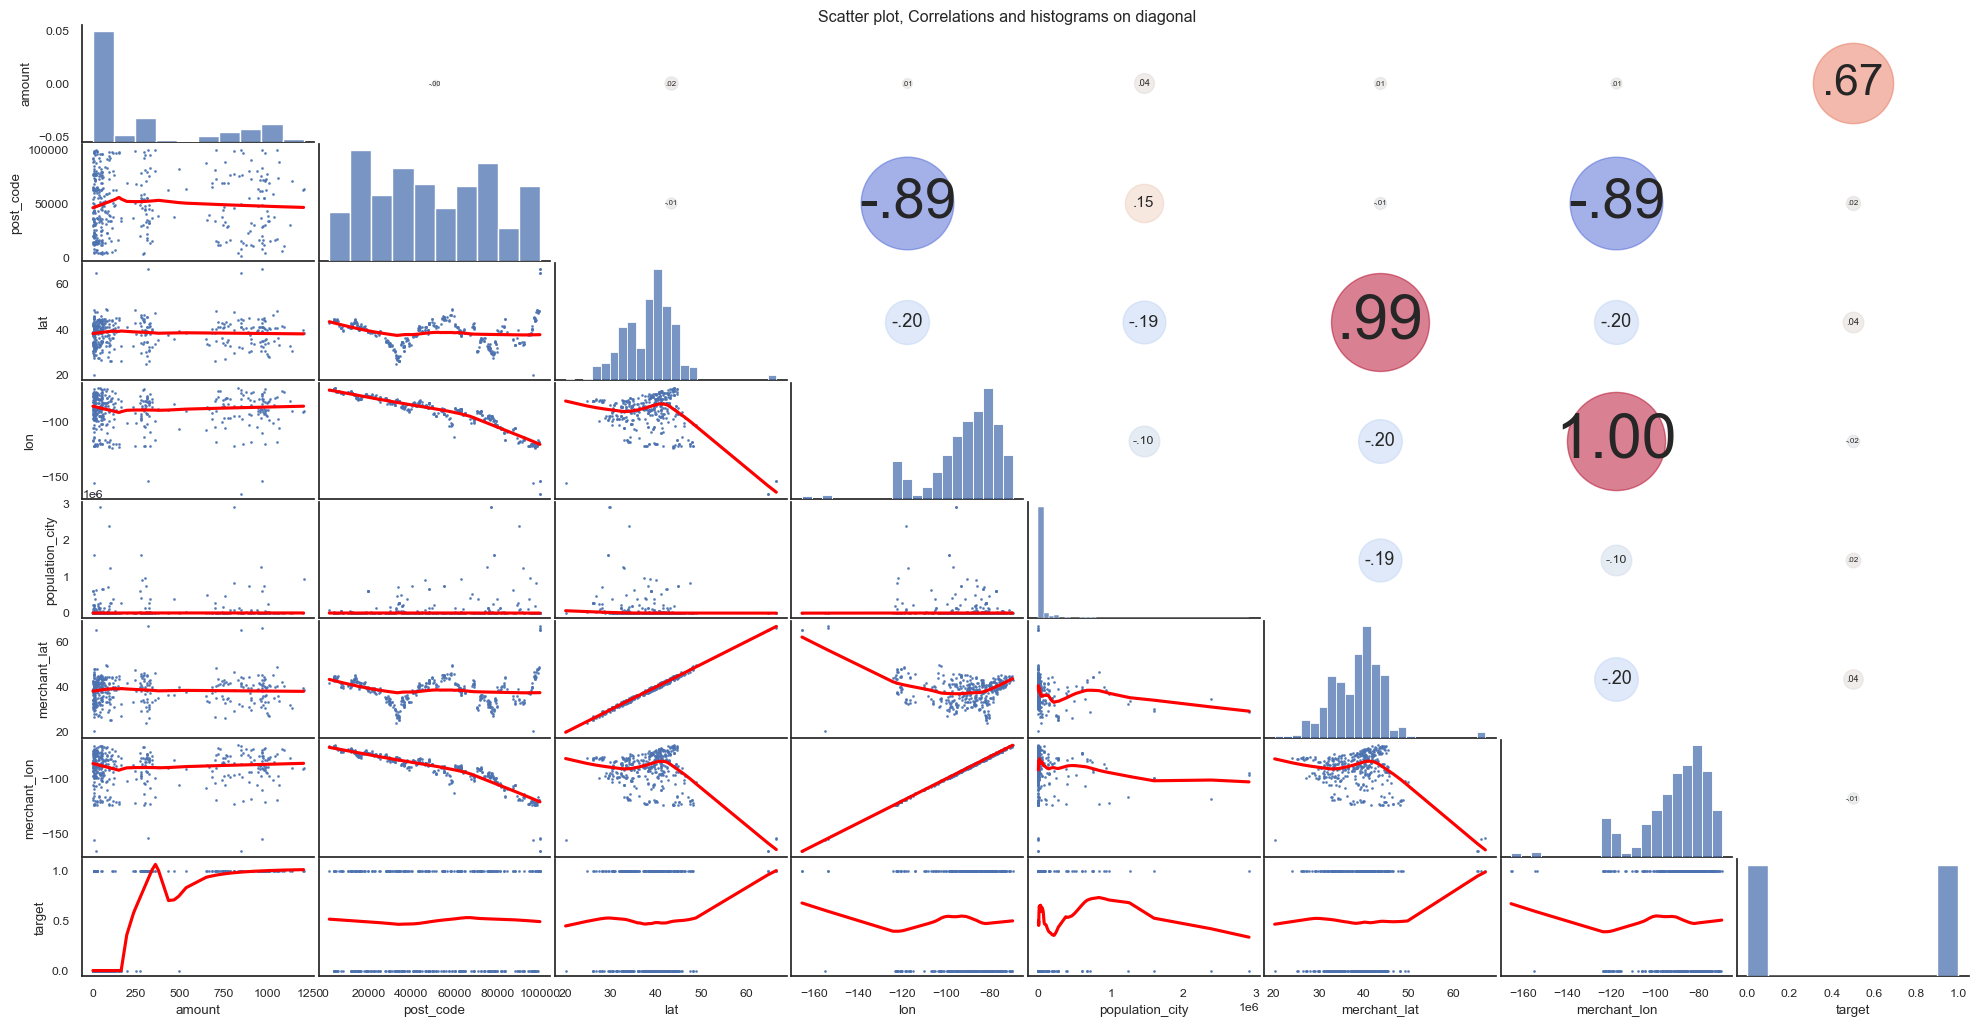

In [11]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set_theme(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.figure.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.figure.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(pd.concat([df_raw[df_raw['target'] == True][numerical_features + ['target']].head(200), df_raw[df_raw['target'] == False][numerical_features + ['target']].head(200)]))


Видно что категория помогает, а на гендер (очевидно) и несколько других числовых параметров не помогают поэтому убиру их чтобы не мешали

In [12]:
df_raw.drop(columns=['gender', 'post_code', 'merchant_lat', 'merchant_lon'], inplace=True)

In [13]:
numerical_features = list(df_raw.select_dtypes(include=['float64', 'int64']).columns)
categorical_features = list(df_raw.select_dtypes(include=['object']).columns)
print(f"Numerical features: {numerical_features}\nCategorical features: {categorical_features}")

Numerical features: ['amount', 'lat', 'lon', 'population_city']
Categorical features: ['cat_id', 'us_state']


### Pipeline

Пайплайн будет состоять из базового сбора фичей и препроцессинга

In [14]:
class ColumnSelector(BaseEstimator, TransformerMixin):
  def __init__(self, keys):
    if isinstance(keys, str):
      self.keys = [keys]
    else:
      self.keys = keys
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X[self.keys]

In [15]:
features = FeatureUnion([
    ('numerical', Pipeline([
        ('selector', ColumnSelector(numerical_features)),
        ('scaler', StandardScaler())
    ])),
    ('categorical', Pipeline([
        ('selector', ColumnSelector(categorical_features)),
        ('OHE', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])),
])

baseline_clf = Pipeline([
    ('features', features),
    ('elastic_net', HistGradientBoostingClassifier()),
]); baseline_clf

,steps,"[('features', ...), ('elastic_net', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('numerical', ...), ('categorical', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,keys,"['amount', 'lat', ...]"
,copy,True


### Training 

Сначала немного экспериментов, потом финальная обучалка и сохраняем веса

In [ ]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

precisions, recalls, f1s = [], [], []

for train_idx, test_idx in tqdm(skf.split(X, y), total=skf.get_n_splits(), desc="Cross-validation"):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    baseline_clf.fit(X_train, y_train)
    y_pred = baseline_clf.predict(X_test)

    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))

print(f"Precision: {np.mean(precisions):.3f}")
print(f"Recall:    {np.mean(recalls):.3f}")
print(f"F1-score:  {np.mean(f1s):.3f}")

Cross-validation:   0%|          | 0/7 [00:00<?, ?it/s]

Precision: 0.834
Recall:    0.798
F1-score:  0.815


Сырая модель получилась даже очень неплохая, но все равно затьюню ее с оптьюной и сохраню веса

In [19]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-4, 1.0, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 500)
    }
    baseline_clf = Pipeline([
        ('features', features),
        ('elastic_net', HistGradientBoostingClassifier(**params, random_state=42)),
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(baseline_clf, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(study.best_params)
print(study.best_value)

[I 2025-10-17 20:53:28,209] A new study created in memory with name: no-name-a6b07063-ef36-4f98-9158-b4816ca865c3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-17 20:55:03,278] Trial 0 finished with value: 0.8430194851932671 and parameters: {'learning_rate': 0.035643472011073395, 'max_depth': 9, 'min_samples_leaf': 93, 'l2_regularization': 0.004097739090690029, 'max_iter': 440}. Best is trial 0 with value: 0.8430194851932671.
[I 2025-10-17 20:55:08,465] Trial 1 finished with value: 0.8127240242734022 and parameters: {'learning_rate': 0.1413736513376887, 'max_depth': 12, 'min_samples_leaf': 29, 'l2_regularization': 0.060135964200926796, 'max_iter': 474}. Best is trial 0 with value: 0.8430194851932671.
[I 2025-10-17 20:55:12,867] Trial 2 finished with value: 0.7587824244683334 and parameters: {'learning_rate': 0.15005301863926387, 'max_depth': 4, 'min_samples_leaf': 62, 'l2_regularization': 0.0007164385107821962, 'max_iter': 429}. Best is trial 0 with value: 0.8430194851932671.
[I 2025-10-17 20:55:43,280] Trial 3 finished with value: 0.819527294680962 and parameters: {'learning_rate': 0.10155601154190669, 'max_depth': 3, 'min_samples

In [16]:
best_params = {'learning_rate': 0.09199468770573896, 'max_depth': 11, 'min_samples_leaf': 22, 'l2_regularization': 0.15942861089288266, 'max_iter': 260}

final_model = Pipeline([
    ('features', features),
    ('clf', HistGradientBoostingClassifier(**best_params, random_state=42))
])

final_model.fit(X, y)

,steps,"[('features', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('numerical', ...), ('categorical', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,keys,"['amount', 'lat', ...]"
,copy,True


In [17]:
joblib.dump(final_model, '../data/model_weights/best_hist_gb_model.pkl')

['../data/model_weights/best_hist_gb_model.pkl']